# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
VAE_TRAIN = False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
from dataloaders import get_mnist_dataloaders_attack
train_loader, test_loader = get_mnist_dataloaders_attack(2, 5, train_batch_size=64, test_batch_size=64, path_to_data='/home/data/bvaa')

### Define latent distribution of the model

In [5]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [10]}

### Build a model

In [6]:
from models import VAE

model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32), use_cuda=True).cuda()

### Train the model

In [8]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [9]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

classifier = Classifier().cuda()
classifier.load_state_dict(torch.load('../VAE/models/mnist_cnn_non_log.pt'))

<All keys matched successfully>

In [10]:
from training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [11]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [46]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
    trainer.train(train_loader, epochs=100)
    torch.save(model.state_dict(), 'models/vae.pth')
else:
    model.load_state_dict(torch.load('models/vae.pth'))
    model.eval()

## Attack

In [13]:
attack_digit = 2
target_digit = 5

In [12]:
# torch.where(example_targets==1)[0].tolist()

In [14]:
class Attack(nn.Module):
    def __init__(self, attack_digit=attack_digit, target_digit=target_digit, vae=model, classifier=classifier):
        super(self, Attack).__init__()
        self.classifier = classifier
        self.classifier.eval()
        self.vae = vae
        self.vae.eval()
        self.attack_digit = attack_digit
        self.target_digit = target_digit
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.hidden_layers.append(latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        _, l_dist = self.vae(x)
        l_sample = self.vae.reparameterize(l_dist)
        noised_sample = l_sample
        for layer in self.layers:
            noised_sample = layer(noised_sample)
        noised_images = self.vae.decoder(noised_sample)
        preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))
        return x

### Visualize

In [47]:
examples = enumerate(test_loader)
batch_idx, example_data = next(examples)

In [48]:
example_data.shape

torch.Size([64, 1, 32, 32])

In [49]:
example_img = example_data[12,:,:,:].unsqueeze(0).cuda()
output, l_dist = model(example_img)

In [50]:
l_sample = model.reparameterize(l_dist)

In [66]:
# new_l_sample = l_sample
new_l_sample = 0.9 * l_sample
new_output = model.decode(new_l_sample)

In [67]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_sim = cos(l_sample, new_l_sample)
print(output_sim)

tensor([1.], device='cuda:0', grad_fn=<DivBackward0>)


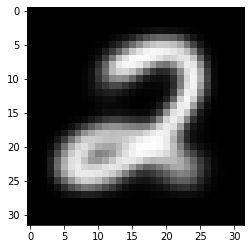

In [68]:
plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

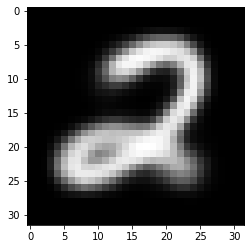

In [58]:
plt.imshow(output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

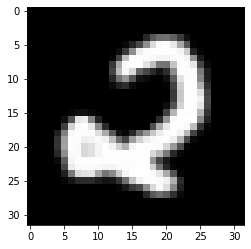

In [56]:
example_img = example_data[12,:,:,:].unsqueeze(0).cuda()
plt.imshow(example_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [57]:
def plot_mnist(list_to_process):
    new_l_sample = None
    count = len(list_to_process)
    for i in list_to_process:
        example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
        output, l_dist = model(example_img)
        l_sample = model.reparameterize(l_dist)
        if new_l_sample is None:
            new_l_sample = l_sample
        else:
            new_l_sample += l_sample
    new_l_sample = new_l_sample / count
    new_output = model.decode(new_l_sample)
    plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [63]:
a = torch.where(example_targets==1)[0].tolist()

In [64]:
a

[1, 17, 23, 28, 35, 58, 62]

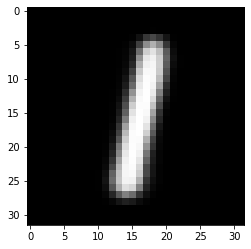

In [73]:
plot_mnist(a)

In [29]:
torch.argmax(classifier(F.upsample(example_img, (28,28), mode='bilinear', align_corners=True)))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor(3, device='cuda:0')

In [30]:
def check(i, j, alpha, beta):
    im1 = example_data[i,:,:,:].unsqueeze(0).cuda()
    im2 = example_data[j,:,:,:].unsqueeze(0).cuda()
    out1, l_dist1 = model(im1)
    out2, l_dist2 = model(im2)
    l_sample1 = model.reparameterize(l_dist1)
    l_sample2 = model.reparameterize(l_dist2)
    l_sample = alpha*l_sample1 + beta*l_sample2
    new_out = model.decode(l_sample)
#     new_out1 = model.decode(l_sample1)
#     new_out2 = model.decode(l_sample2)
    plt.figure(figsize=(10,15))
    plt.subplot(1,3,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,2)
    plt.imshow(example_data[j][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,3)
    plt.imshow(new_out[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    print(torch.argmax(classifier(F.upsample(new_out, (28,28), mode='bilinear', align_corners=True))))

tensor(5, device='cuda:0')


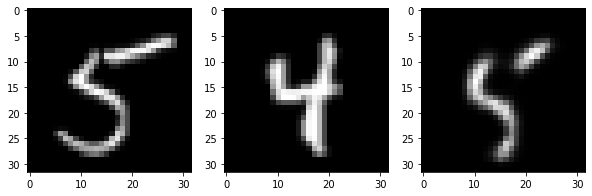

In [31]:
alpha=1
beta = 1.2
check(19,11, alpha, beta)

In [392]:
from tqdm.notebook import tqdm
attack_log_interval = 1
alt_target = 0
translator.train()
optimizer = optim.Adam(translator.parameters(), lr=1e-5)
for epoch in tqdm(range(20)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.FloatTensor(data).to(device)
        
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        noised_sample = translator(l_sample)
        loss, correct = tloss(noised_sample, l_sample, alt_target)
        loss.backward()
        optimizer.step()
#         print(correct)
        epoch_loss += loss.item()
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

Train Epoch: 0	Loss: 355.146811	Correct: 240
Train Epoch: 1	Loss: 155.563796	Correct: 55199
Train Epoch: 2	Loss: 108.466862	Correct: 60000
Train Epoch: 3	Loss: 81.091524	Correct: 59922
Train Epoch: 4	Loss: 58.762144	Correct: 60000
Train Epoch: 5	Loss: 55.665399	Correct: 60000
Train Epoch: 6	Loss: 54.086596	Correct: 60000
Train Epoch: 7	Loss: 52.544739	Correct: 60000
Train Epoch: 8	Loss: 51.672013	Correct: 60000
Train Epoch: 9	Loss: 51.175964	Correct: 60000
Train Epoch: 10	Loss: 50.793209	Correct: 60000
Train Epoch: 11	Loss: 50.632449	Correct: 60000
Train Epoch: 12	Loss: 50.446061	Correct: 60000
Train Epoch: 13	Loss: 50.355388	Correct: 60000
Train Epoch: 14	Loss: 50.269844	Correct: 60000
Train Epoch: 15	Loss: 50.243272	Correct: 60000
Train Epoch: 16	Loss: 50.258003	Correct: 60000
Train Epoch: 17	Loss: 50.282607	Correct: 60000
Train Epoch: 18	Loss: 50.286113	Correct: 60000
Train Epoch: 19	Loss: 50.258231	Correct: 59999



In [450]:
total_correct = 0
total_test = 0
for batch_idx, (data, target) in enumerate(test_loader):
    total_test += data.shape[0]
    data = torch.FloatTensor(data).to(device)

    _, l_dist = model(data)
    l_sample = model.reparameterize(l_dist)

    noised_sample = translator(l_sample)
#     noised_sample = 1 * l_sample + 6e-7 * noised_sample #2
    noised_sample = 1 * l_sample + 2e-2 * noised_sample #0
    loss, correct = tloss(noised_sample, l_sample, alt_target)
    total_correct += correct
#     print(correct)
#         loss.backward()
#         optimizer.step()
#         print(correct)
#         epoch_loss += loss.item()
    

#     if (epoch+1) % attack_log_interval == 0:
#         print('Train Epoch: \tCorrect: {}'.format(
#             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

7207
Accuracy:  72.07000000000001


In [451]:
def test(i):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    noised_sample = translator(l_sample)
    print(noised_sample)
    print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
    noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(noised_sample)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)))
    print("Prediction: {}, {}".format(pred_org.item(), pred.item()))
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

tensor([[-3.6366, -3.1751,  6.1095,  1.6212,  0.8919, -5.7888, -5.0468, -4.4371,
          6.0394, -1.3505,  3.0333, -5.3019,  2.9255,  4.8683,  1.7715,  2.1769,
          0.6416,  3.2473,  5.5838, -5.2517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0280,  0.4251,  0.0480, -0.0193, -0.0128, -0.5147,  0.7122,  0.6263,
         -0.0048,  1.1076,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0',
       grad_fn=<CatBackward>)
Prediction: 3, 0


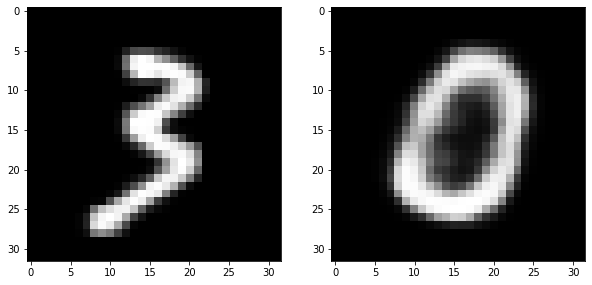

In [462]:
test(23)